# Mask maker

In [1]:
import sys
import os
import numpy as np
sys.path.append(os.path.join('..', 'src'))
from maskmaker import MaskMaker

**Set your own numbers**

In [2]:
mm = MaskMaker(
    nRegions=4,
    xyTranslations=[(60,55),(22,45),(55,75),(184,200)],
    polyEdges=[4,5,16,3],
    imageSize=(256,256),
    randSeed=1216137,
    rescaler=10
)

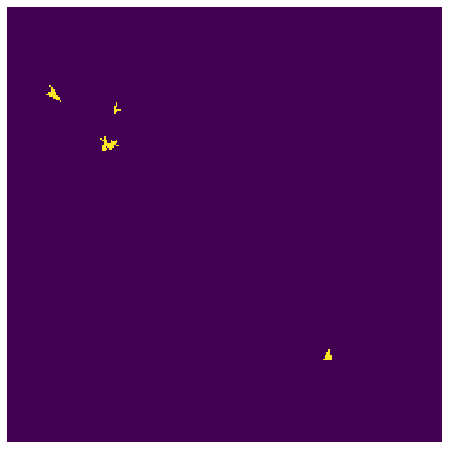

In [3]:
mm.viewMask()

**Generate random polygons**

In [4]:
np.random.seed(420)

In [5]:
random_positions = [(np.random.randint(256), np.random.randint(256)) for i in range(20)]
random_edges = [np.random.randint(3,8) for i in range(20)]

In [6]:
mm2 = MaskMaker(
    nRegions=15,
    xyTranslations=random_positions,
    polyEdges=random_edges,
    imageSize=(256,256),
    randSeed=420,
    rescaler=21
)

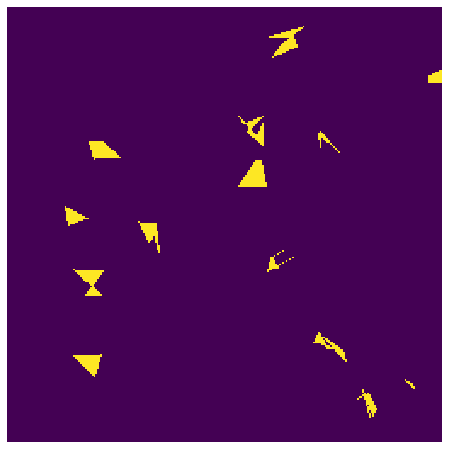

In [7]:
mm2.viewMask()